# Analysis of dating for internal nodes

First we do a check of internal consistency for node dating. We take matched sample nodes and re-date them, then compare the inferred dates to the true dates. 

In [1]:
import numpy as np
import nb_utils
import sc2ts
import collections
from collections import defaultdict
import random
import tskit
import tszip
import csv
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import stats

In [ ]:
trees_dir = "/trees/"

In [ ]:
# Node 0 is disconnected - adding one edge to node 1 to fix
# ts = tszip.decompress(trees_dir + "sc2ts_viridian_v1.2.trees.tsz")
# tables = ts.dump_tables()
# tables.edges.add_row(left=0, right=ts.sequence_length, parent=0, child=1)
# tables.sort()
# ts = tables.tree_sequence()
# tszip.compress(ts, trees_dir + "sc2ts_viridian_v1.2_connected.trees.tsz")

After re-running the dating script `run_nonsample_dating` on the final (postprocessed ARG) it looks like nodes are re-dated, and they are all scrictly slightly older than before.

In [4]:
ts_old = tszip.decompress(trees_dir + "sc2ts_viridian_v1.2_connected.trees.tsz")
ts = tszip.decompress(trees_dir + "sc2ts_viridian_v1.2_connected.trees.dated.tsz")

In [5]:
internal_nodes = set([n.id for n in ts.nodes() if not n.is_sample()])
sample_nodes = set(ts.samples())
total_internal = len(internal_nodes)
total_internal

265828

In [6]:
node_times = ts.nodes_time
node_times_old = ts_old.nodes_time

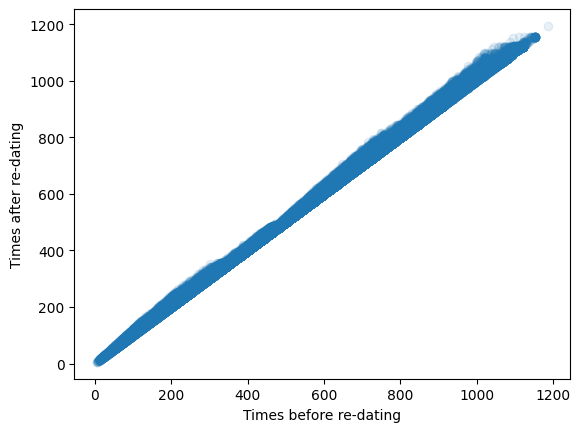

In [5]:
plt.scatter(
    [node_times_old[i] for i in internal_nodes], 
    [node_times[i] for i in internal_nodes], 
    alpha = 0.1
)
plt.xlabel("Times before re-dating")
plt.ylabel("Times after re-dating")
plt.show()

Will use the re-dated version for the rest of this.

## Re-dating sample nodes

We will:
- compute node times and the number of children (averaged across trees) for internal nodes
- sample 265828 nodes from among the sample nodes, matching the distribution of times and children

In [6]:
def get_avg_children(ts):
    num_nodes = ts.num_nodes
    total_children = np.zeros(num_nodes, dtype=int)
    num_trees_with_node = np.zeros(num_nodes, dtype=int)

    for tree in tqdm(ts.trees(), total=ts.num_trees):
        for u in range(num_nodes):
            if tree.parent(u) != tskit.NULL or u in tree.roots:
                num_trees_with_node[u] += 1
                total_children[u] += len(tree.children(u))
    
    return np.divide(
        total_children,
        num_trees_with_node,
        out=np.zeros_like(total_children, dtype=float),
        where=num_trees_with_node != 0
    )

avg_children = get_avg_children(ts)

  0%|          | 0/316 [00:00<?, ?it/s]

Plotting histograms of the times and number of children for internal and sample nodes:

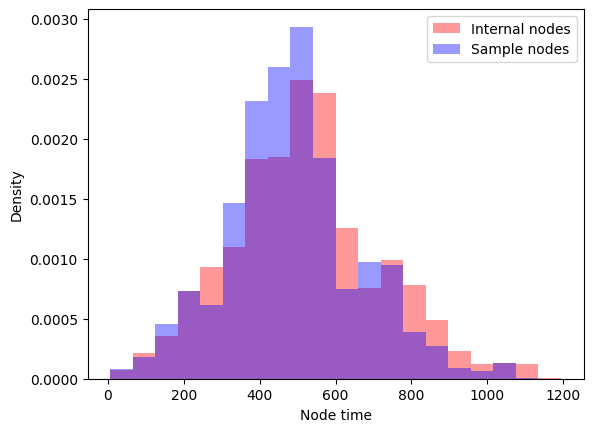

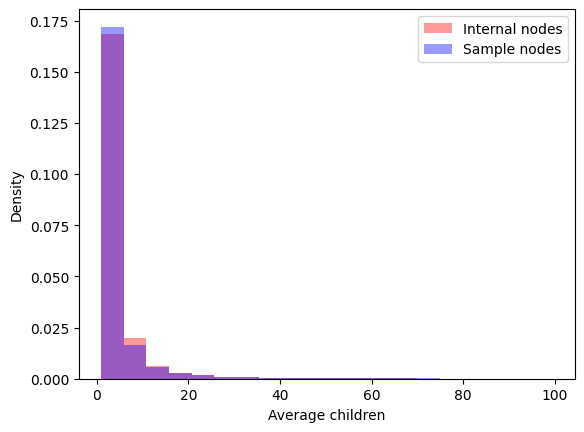

In [58]:
eligible_sample_nodes = [
    node_id for node_id in sample_nodes if avg_children[node_id] > 0
]

bins_time = plt.hist(
    [node_times[i] for i in internal_nodes],
    color="red", alpha=0.4, density=True, label="Internal nodes", bins=20
)
plt.hist(
    [node_times[i] for i in eligible_sample_nodes],
    color="blue", alpha=0.4, density=True, bins=bins_time[1], label="Sample nodes"
)
plt.legend()
plt.xlabel("Node time")
plt.ylabel("Density")
plt.show()

bins_children = plt.hist(
    [avg_children[i] for i in internal_nodes if avg_children[i] < 100],
    color="red", alpha=0.4, density=True, label="Internal nodes", bins=20
)
plt.hist(
    [avg_children[i] for i in eligible_sample_nodes if avg_children[i] < 100],
    color="blue", alpha=0.4, density=True, bins=bins_children[1], label="Sample nodes"
)
plt.legend()
plt.xlabel("Average children")
plt.ylabel("Density")
plt.show()

These don't quite match, so will try to do something more fancy than uniform random sampling.

In [40]:
print(f"Original sample nodes: {len(sample_nodes)}. Eligible sample nodes: {len(eligible_sample_nodes)}")

internal_props = np.array(
    [(node_times[i], np.log(avg_children[i])) for i in internal_nodes if avg_children[i] > 0]
)
sample_props = np.array(
    [(node_times[i], np.log(avg_children[i])) for i in eligible_sample_nodes]
)
sample_nodes_list = eligible_sample_nodes

bins_range = [
    [internal_props[:, 0].min(), internal_props[:, 0].max()],
    [internal_props[:, 1].min(), internal_props[:, 1].max()],
]
num_bins = 20

pdf_internal, x_edges, y_edges = np.histogram2d(
    internal_props[:, 0], internal_props[:, 1], bins=num_bins, range=bins_range, density=True
)
pdf_sample, _, _ = np.histogram2d(
    sample_props[:, 0], sample_props[:, 1], bins=[x_edges, y_edges], density=True
)

internal_bin_x = np.clip(np.digitize(internal_props[:, 0], x_edges) - 1, 0, num_bins - 1)
internal_bin_y = np.clip(np.digitize(internal_props[:, 1], y_edges) - 1, 0, num_bins - 1)
sample_bin_x = np.clip(np.digitize(sample_props[:, 0], x_edges) - 1, 0, num_bins - 1)
sample_bin_y = np.clip(np.digitize(sample_props[:, 1], y_edges) - 1, 0, num_bins - 1)

target_counts = defaultdict(int)
for bx, by in zip(internal_bin_x, internal_bin_y):
    target_counts[(bx, by)] += 1

candidate_pools = defaultdict(list)
for i, (bx, by) in enumerate(zip(sample_bin_x, sample_bin_y)):
    candidate_pools[(bx, by)].append(i)

stratified_indices = []
for bin_coords, target_num in target_counts.items():
    pool = candidate_pools[bin_coords]
    num_to_draw = min(target_num, len(pool))
    if num_to_draw > 0:
        drawn_indices = random.sample(pool, k=num_to_draw)
        stratified_indices.extend(drawn_indices)

# Check how many we have sampled
print(f"Sampled {len(stratified_indices)} nodes.")

shortfall = total_internal - len(stratified_indices)

if shortfall > 0:
    # Identify remaining candidates that were not chosen already
    all_indices_set = set(range(len(sample_nodes_list)))
    stratified_indices_set = set(stratified_indices)
    remaining_indices = np.array(list(all_indices_set - stratified_indices_set))

    # Calculate importance weights for remaining candidates
    rem_bin_x = sample_bin_x[remaining_indices]
    rem_bin_y = sample_bin_y[remaining_indices]
    
    f_values_rem = pdf_internal[rem_bin_x, rem_bin_y]
    g_values_rem = pdf_sample[rem_bin_x, rem_bin_y]
    
    epsilon = 1e-10
    weights = f_values_rem / (g_values_rem + epsilon)
    
    # Weighted random sample on the remaining pool
    if np.sum(weights) > 0 and len(remaining_indices) >= shortfall:
        weights /= np.sum(weights)
        top_up_indices = np.random.choice(
            remaining_indices, size=shortfall, replace=False, p=weights
        )
    else:
        print("Warning: Using simple random sampling.")
        top_up_indices = np.random.choice(
            remaining_indices, size=shortfall, replace=False
        )
    
    # Combine the two sets of indices
    final_indices = np.concatenate([stratified_indices, top_up_indices])
    print(f"Added {len(top_up_indices)} nodes to meet required sample size.")

else:
    final_indices = np.array(stratified_indices)

random_subset_matched = {sample_nodes_list[i] for i in final_indices}
print(f"Final sample size: {len(random_subset_matched)} nodes")

Original sample nodes: 2482157. Eligible sample nodes: 278534
Sampled 140849 nodes.
Added 124979 nodes to meet required sample size.
Final sample size: 265828 nodes


Clearly shouldn't make a big difference how you sample here, since number of internal sample nodes is not far from number of internal nodes. 

In [42]:
# with open('matched_nodes.csv', 'w', newline='') as f:
#     writer = csv.writer(f)
#     for node_id in random_subset_matched:
#         writer.writerow([node_id])

In [3]:
# with open('matched_nodes.csv', 'r') as f:
#     reader = csv.reader(f)
#     random_subset_matched = [int(row[0]) for row in reader]

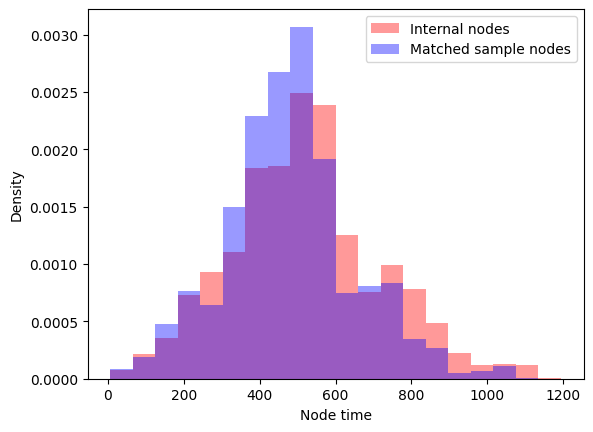

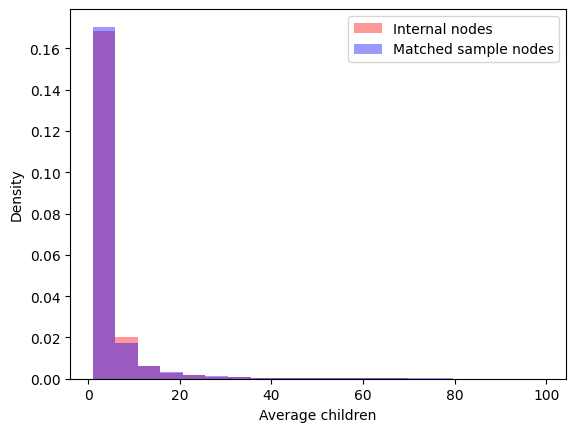

In [41]:
bins_time = plt.hist(
    [node_times[i] for i in internal_nodes],
    color="red", alpha=0.4, density=True, label="Internal nodes", bins=20
)
plt.hist(
    [node_times[i] for i in random_subset_matched],
    color="blue", alpha=0.4, density=True, bins=bins_time[1], label="Matched sample nodes"
)
plt.legend()
plt.xlabel("Node time")
plt.ylabel("Density")
plt.show()

bins_children = plt.hist(
    [avg_children[i] for i in internal_nodes if avg_children[i] < 100],
    color="red", alpha=0.4, density=True, label="Internal nodes", bins=20
)
plt.hist(
    [avg_children[i] for i in random_subset_matched if avg_children[i] < 100],
    color="blue", alpha=0.4, density=True, bins=bins_children[1], label="Matched sample nodes"
)
plt.legend()
plt.xlabel("Average children")
plt.ylabel("Density")
plt.show()

In [43]:
max([avg_children[i] for i in internal_nodes])

np.float64(12682.879746835442)

In [44]:
max([avg_children[i] for i in random_subset_matched])

np.float64(2759.9208860759495)

In [45]:
len([avg_children[i] for i in internal_nodes if avg_children[i] > 100])

803

In [46]:
len([avg_children[i] for i in random_subset_matched if avg_children[i] > 100])

770

In [47]:
np.mean([avg_children[i] for i in internal_nodes])

np.float64(5.555937319229736)

In [48]:
np.mean([avg_children[i] for i in random_subset_matched])

np.float64(4.642527191847476)

In [49]:
# Edit the tree sequence to set all internal nodes as samples (so that the times of these are fixed)
# and the selected nodes as non-samples (so that the times of these are re-estimated)
tables = ts.dump_tables()
for s in tqdm(internal_nodes, total=total_internal):
    n = ts.node(s)
    new_flags = int(tables.nodes.flags[s]) & tskit.NODE_IS_SAMPLE
    tables.nodes[s] = tables.nodes[s].replace(flags=new_flags)
for s in tqdm(random_subset_matched, total=total_internal):
    n = ts.node(s)
    new_flags = int(tables.nodes.flags[s]) & ~tskit.NODE_IS_SAMPLE
    tables.nodes[s] = tables.nodes[s].replace(flags=new_flags)
ts_masked = tables.tree_sequence()
tszip.compress(ts_masked, trees_dir + "sampled.trees.tsz")

  0%|          | 0/265828 [00:00<?, ?it/s]

  0%|          | 0/265828 [00:00<?, ?it/s]

Then we run the dating script `run_nonsample_dating` on the new ts. 

In [9]:
ts_redated_sampled = tszip.decompress(trees_dir + "sampled.trees.dated.tsz")

In [10]:
node_times_sample = ts_redated_sampled.nodes_time

Check sample nodes have not been re-dated

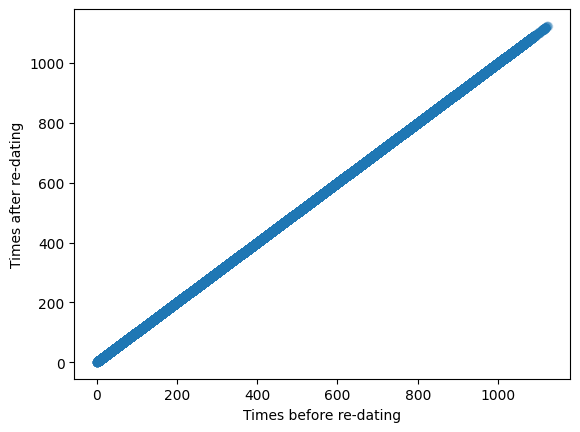

In [52]:
plt.scatter(
    [node_times[i] for i in sample_nodes if i not in random_subset_matched], 
    [node_times_sample[i] for i in sample_nodes if i not in random_subset_matched], 
    alpha = 0.1)
plt.xlabel("Times before re-dating")
plt.ylabel("Times after re-dating")
plt.show()

Plot histogram of the differences before and after re-dating

In [11]:
t1 = [node_times[i] for i in random_subset_matched]
t2 = [node_times_sample[i] for i in random_subset_matched]
differences = np.array(t2) - np.array(t1)

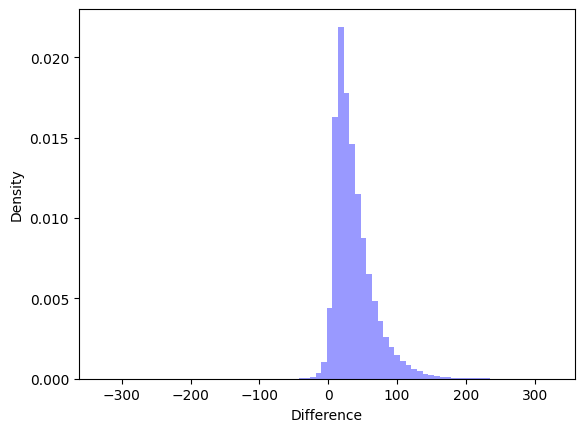

In [12]:
plt.hist(
    differences,
    color="blue", alpha=0.4, density=True, bins=80,
)
plt.xlabel("Difference")
plt.ylabel("Density")
plt.show()

In [71]:
np.mean(differences)

np.float64(37.43007895266343)

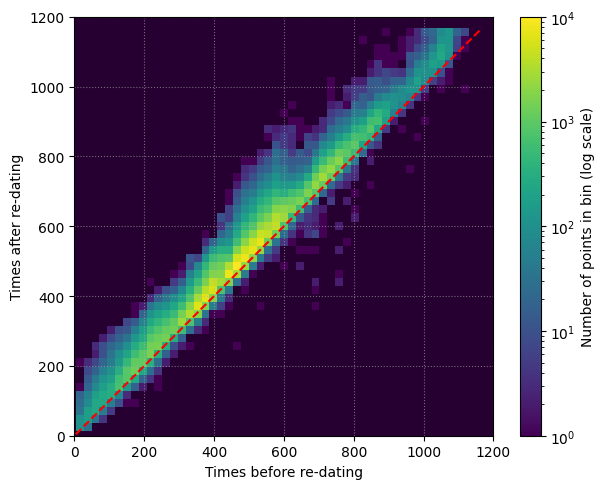

In [54]:
fig, ax = plt.subplots(figsize=(6.2,5))

counts, xedges, yedges, im = plt.hist2d(
    t1, t2, bins=50, cmap='viridis',
    norm=colors.LogNorm(),
)

cbar = plt.colorbar(im)
cbar.set_label('Number of points in bin (log scale)')

min_val = min(np.min(t1), np.min(t2))
max_val = max(np.max(t1), np.max(t2))

plt.plot([min_val, max_val], [min_val, max_val], 'r--')
ax.set_facecolor('#260031')
plt.xlabel('Times before re-dating')
plt.ylabel('Times after re-dating')
plt.ylim([0, 1200])
plt.xlim([0, 1200])
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.savefig('../figures/node_time_testing.pdf')

## Checking against Nextstrain times

In [39]:
pn_map = {}
with open('../data/pango_to_nextstrain_map.tsv', 'r') as f:
    next(f)
    for line in f:
        line = line.strip().split('\t')
        pn_map[line[0]] = line[1]

In [40]:
pango = {}
with open('../data/pango_events_in_arg.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        node_id = int(row[1])
        node = ts_old.node(int(row[1]))
        node_time = node.time
        node_pango = row[0]
        if node_pango not in pn_map:
            print("Not in map:", node_pango)
        else:
            node_clade = pn_map[node_pango]
            if node_clade not in pango:
                pango[node_clade] = [node_id, node_time, node_pango, node.is_sample()]
            else:
                if node_time > pango[node_clade][1]:
                    pango[node_clade] = [node_id, node_time, node_pango, node.is_sample()]

Not in map: B.1.1.529


In [41]:
nextstrain = {}
with open('../data/oldest_clade_nodes.tsv', 'r') as f:
    next(f)
    for line in f:
        line = line.strip().split('\t')
        clade = line[0].strip().split()[0]
        ci = line[3][1:-1].strip().split(",")
        nextstrain[clade] = [float(line[2]), float(ci[0]), float(ci[1])]

In [42]:
def convert_time(t):
    return 2023.13972603 - t/365.0

In [43]:
missing_keys1 = [k for k in nextstrain.keys() if k not in pango.keys()]
missing_keys2 = [k for k in pango.keys() if k not in nextstrain.keys()]
missing_keys1, missing_keys2

(['21M'], ['23C', '23D', '23A', 'recombinant'])

In [44]:
keys = [k for k in pango.keys() if k in nextstrain.keys()]
x_values = np.array([nextstrain[key][0] for key in keys])
x_left = np.array([nextstrain[key][1] for key in keys])
x_right = np.array([nextstrain[key][2] for key in keys])
left_error = x_values - x_left
right_error = x_right - x_values
errors = [left_error, right_error]
y_values = np.array([convert_time(pango[key][1]) for key in keys])
all_values = np.concatenate([x_values, y_values])
min_val = np.min(all_values)
max_val = np.max(all_values)
line_points = [min_val, max_val]

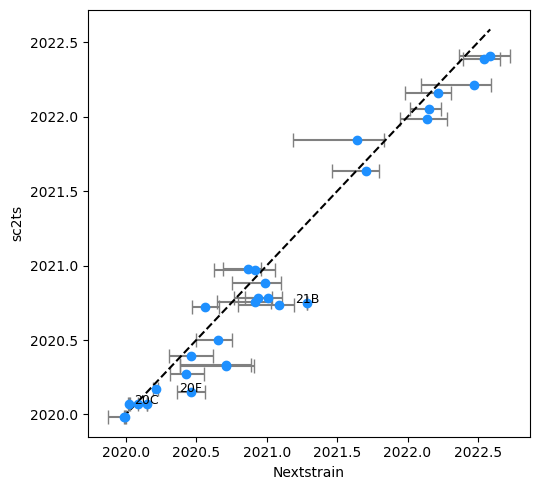

In [55]:
plt.figure(figsize=(5.5, 5))
plt.errorbar(x_values, y_values,
             xerr=errors,
             fmt='o',
             color='dodgerblue',
             ecolor='gray',
             capsize=5,
             linestyle='None',
            )
plt.plot(line_points, line_points, color='black', linestyle='--')
for i in range(len(x_values)):
    if y_values[i] < x_left[i] - 28/365 or y_values[i] > x_right[i] + 218365:
        plt.text(x_values[i], y_values[i], keys[i], fontsize=9, ha='center') # ha='center' centers the text
plt.xlabel('Nextstrain')
plt.ylabel('sc2ts')
plt.tight_layout()
plt.savefig('../figures/pango_vs_nextstrain_node_times.pdf')